This notebook calculates coherence in LS for sequential igrams vs. skip1 igrams. It also calculates coherence in ALL of LS over time vs. everywhere else. 

This notebook was written on 3-31-23

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

Load coherence files.

In [2]:
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
saveDir = '/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/'

# Sequential.
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'_'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps (sequential) loaded.')

Coh maps (sequential) loaded.


In [5]:
# Skip1. 
numIgrams_skip1 = numIgrams-1
coh_skip1 = np.ndarray((numIgrams_skip1,dy,dx),dtype='float')
for i in range(numIgrams_skip1): #range(numIgrams_skip1)
    date1=dates[i]
    date2=dates[i+2]
    file_name = 'coh_'+str(date1)+'-'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh_skip1[i] = f1.ReadAsArray()
f1 = None
print('Coh maps (skip1) loaded.')

0
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170510-20170603.r4
1
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170522-20170615.r4
2
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170603-20170627.r4
3
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170615-20170709.r4
4
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170627-20170721.r4
5
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170709-20170802.r4
6
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170721-20170814.r4
7
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170802-20170826.r4
8
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170814-20170907.r4
9
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170826-20170919.r4
10
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh_20170907-20171013.r4
11
/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/coh

Load in mask files. LS and Mountains.

In [6]:
# load LS and mtns masks.
maskdir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
LS_file = 'LS_mask.r4'
ds = gdal.Open(maskdir+LS_file,gdal.GA_ReadOnly)
LS_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
LS_y,LS_x = np.nonzero(LS_mask)
print('LS mask loaded.')
mtns_file = 'mtns_mask.r4'
ds = gdal.Open(maskdir+mtns_file,gdal.GA_ReadOnly)
mtns_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mtns_y,mtns_x = np.nonzero(mtns_mask)
print('mtns mask loaded.')

LS mask loaded.
mtns mask loaded.


Find pixels that are neither in LS or mountains (open desert).

In [7]:
desert_mask = np.ones(np.shape(mtns_mask))
desert_mask[LS_y,LS_x] = 0.0
desert_mask[mtns_y,mtns_x] = 0.0
desert_y,desert_x = np.nonzero(desert_mask)

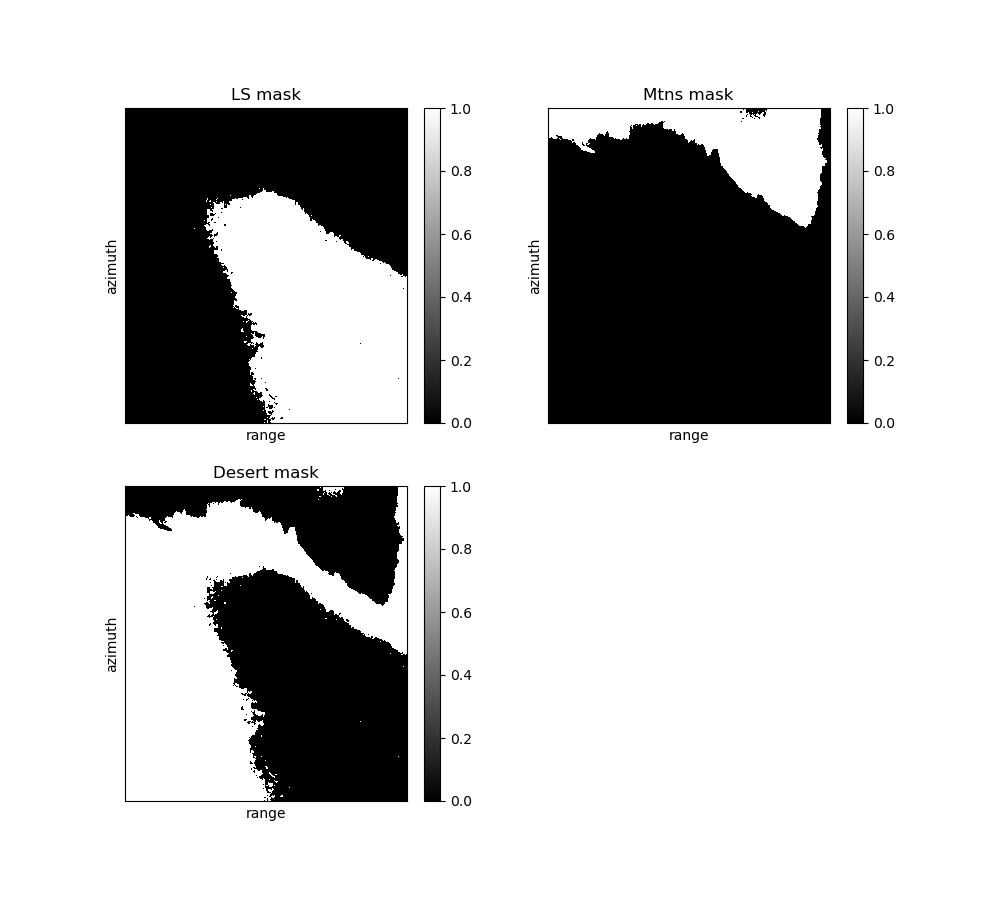

In [8]:
# plot them. 
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.imshow(LS_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS mask') ; plt.colorbar(); 
plt.subplot(2,2,2)
plt.imshow(mtns_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Mtns mask') ; plt.colorbar(); 
plt.subplot(2,2,3)
plt.imshow(desert_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Desert mask') 
plt.colorbar(); 
plt.show()

Calculate average coherence in LS over time. 

In [13]:
# initialize a bunch of arrays 
coh_LS = np.ndarray((numIgrams,),dtype='float')
std_LS = np.ndarray((numIgrams,),dtype='float')
coh_skip1_LS = np.ndarray((numIgrams_skip1,),dtype='float')
std_skip1_LS = np.ndarray((numIgrams_skip1,),dtype='float')
coh_mtns = np.ndarray((numIgrams,),dtype='float')
std_mtns = np.ndarray((numIgrams,),dtype='float')
coh_skip1_mtns = np.ndarray((numIgrams_skip1,),dtype='float')
std_skip1_mtns = np.ndarray((numIgrams_skip1,),dtype='float')
coh_desert = np.ndarray((numIgrams,),dtype='float')
std_desert = np.ndarray((numIgrams,),dtype='float')
coh_skip1_desert = np.ndarray((numIgrams_skip1,),dtype='float')
std_skip1_desert = np.ndarray((numIgrams_skip1,),dtype='float')
# Sequential.
for i in range(numIgrams):
    coh_LS[i] = np.mean(coh[i,LS_y,LS_x])
    std_LS[i] = np.std(coh[i,LS_y,LS_x])
    coh_mtns[i] = np.mean(coh[i,mtns_y,mtns_x])
    std_mtns[i] = np.std(coh[i,mtns_y,mtns_x])
    coh_desert[i] = np.mean(coh[i,desert_y,desert_x])
    std_desert[i] = np.std(coh[i,desert_y,desert_x])
print('Sequential coh and std calculated.')
# Skip1.
for i in range(numIgrams_skip1):
    coh_skip1_LS[i] = np.mean(coh_skip1[i,LS_y,LS_x])
    std_skip1_LS[i] = np.std(coh_skip1[i,LS_y,LS_x])
    coh_skip1_mtns[i] = np.mean(coh_skip1[i,mtns_y,mtns_x])
    std_skip1_mtns[i] = np.std(coh_skip1[i,mtns_y,mtns_x])
    coh_skip1_desert[i] = np.mean(coh_skip1[i,desert_y,desert_x])
    std_skip1_desert[i] = np.std(coh_skip1[i,desert_y,desert_x])
print('Skip1 coh and std calculated.')

Sequential coh and std calculated.
Skip1 coh and std calculated.


Make dates into datetime objects and load rain events.

In [14]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
igram_dates_skip1 = slc_dates[2::] # second SLC date for skip1 pairs 

# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
55	2019-03-13 00:00:00    0.0762 cm
59	2019-05-12 00:00:00    0.10160000000000001 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
86	2019-12-08 00:00:00    0.254 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
103	2020-03-19 00:00:00    0.254 cm
107	2020-04-12 00:00:00    0.9906 cm
154	2021-01-25 00:00:00    0.0762 cm
186	2021-08-11 00:00:00    0.381 cm


Plot coherence over time for each groups of pixels.

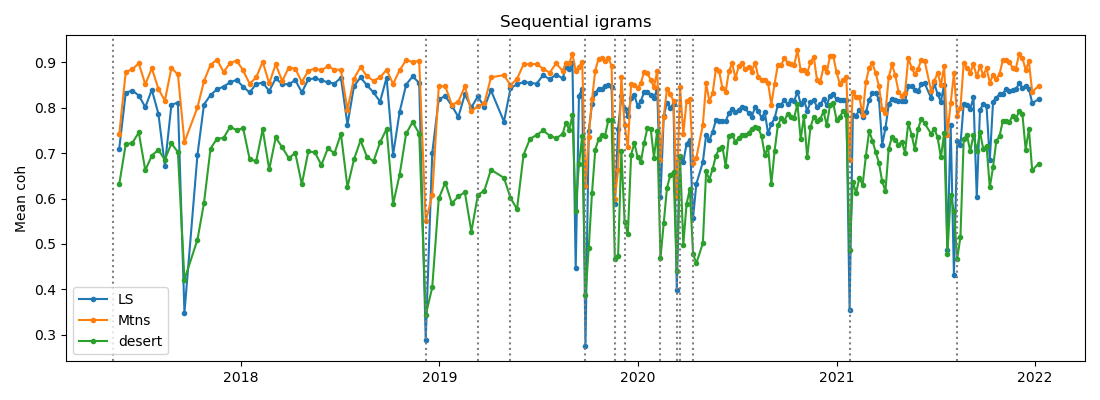

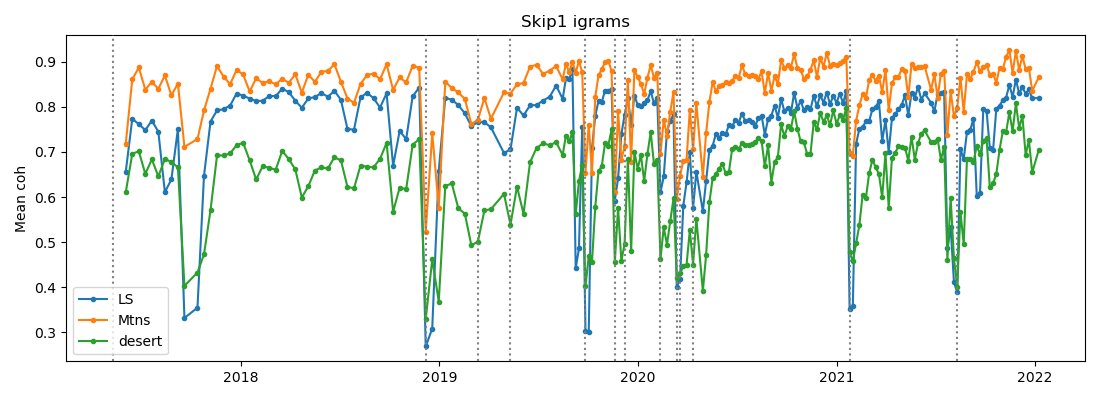

In [15]:
plt.figure(figsize=(11,4),tight_layout=True)
plt.plot(igram_dates,coh_LS,'.-',label='LS')
plt.plot(igram_dates,coh_mtns,'.-',label='Mtns')
plt.plot(igram_dates,coh_desert,'.-',label='desert')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Sequential igrams')
plt.ylabel('Mean coh')
plt.show()

plt.figure(figsize=(11,4),tight_layout=True)
plt.plot(igram_dates_skip1,coh_skip1_LS,'.-',label='LS')
plt.plot(igram_dates_skip1,coh_skip1_mtns,'.-',label='Mtns')
plt.plot(igram_dates_skip1,coh_skip1_desert,'.-',label='desert')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Skip1 igrams')
plt.ylabel('Mean coh')
plt.show()

Plot standard deviation of coherence over time for each surface type.

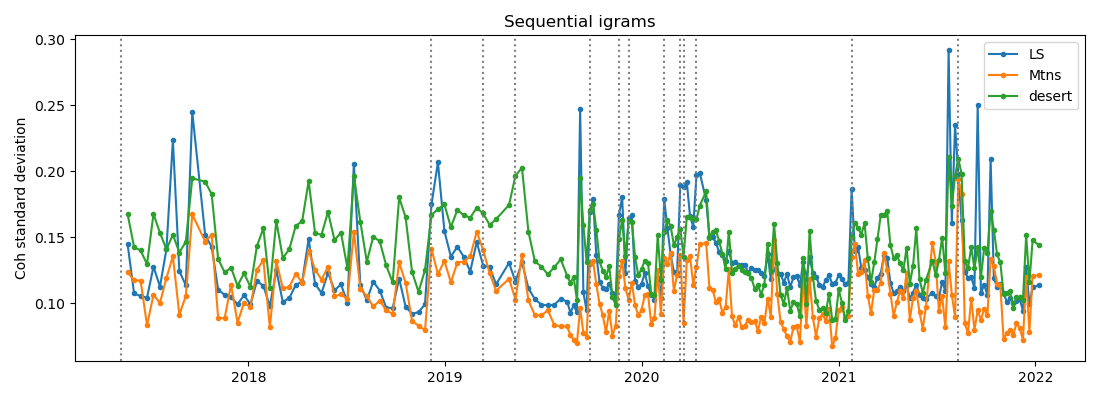

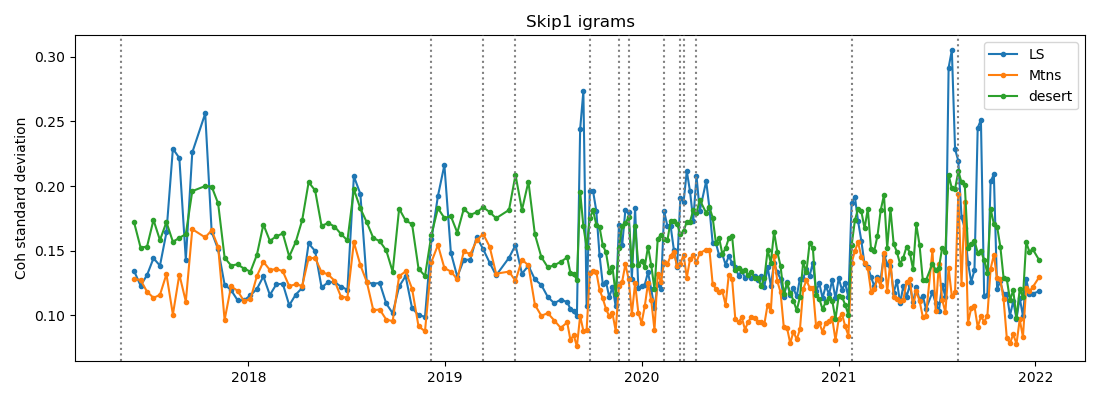

In [16]:
plt.figure(figsize=(11,4),tight_layout=True)
plt.plot(igram_dates,std_LS,'.-',label='LS')
plt.plot(igram_dates,std_mtns,'.-',label='Mtns')
plt.plot(igram_dates,std_desert,'.-',label='desert')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Sequential igrams')
plt.ylabel('Coh standard deviation')
plt.show()

plt.figure(figsize=(11,4),tight_layout=True)
plt.plot(igram_dates_skip1,std_skip1_LS,'.-',label='LS')
plt.plot(igram_dates_skip1,std_skip1_mtns,'.-',label='Mtns')
plt.plot(igram_dates_skip1,std_skip1_desert,'.-',label='desert')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Skip1 igrams')
plt.ylabel('Coh standard deviation')
plt.show()

Plot sequential coh vs. skip1 coh over time for each surface type.

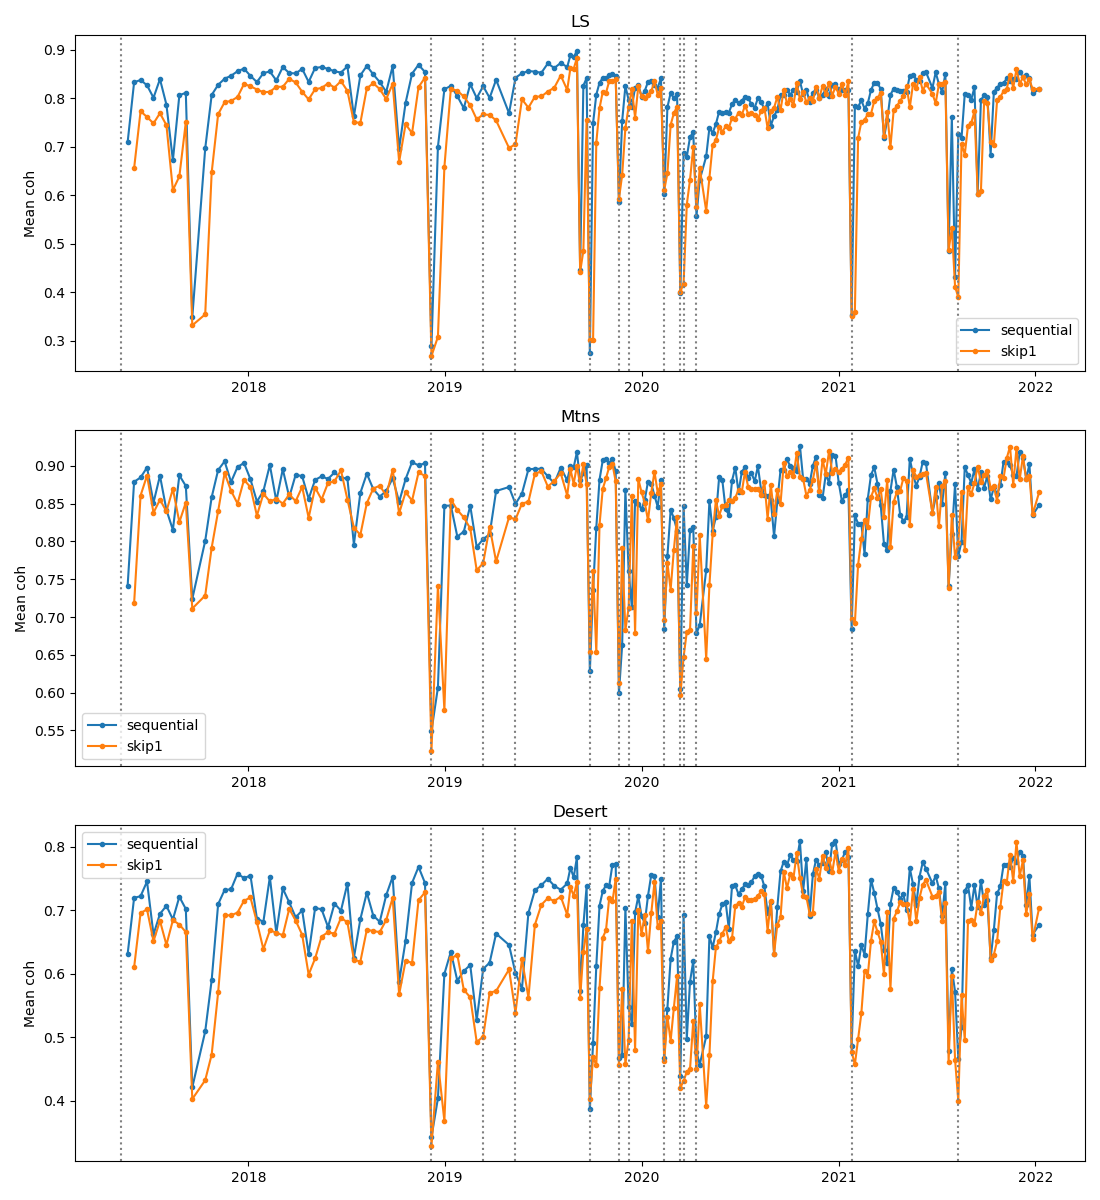

In [20]:
plt.figure(figsize=(11,4*3),tight_layout=True)

plt.subplot(3,1,1)
plt.plot(igram_dates,coh_LS,'.-',label='sequential')
plt.plot(igram_dates_skip1,coh_skip1_LS,'.-',label='skip1')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Mean coh')
plt.title('LS')

plt.subplot(3,1,2)
plt.plot(igram_dates,coh_mtns,'.-',label='sequential')
plt.plot(igram_dates_skip1,coh_skip1_mtns,'.-',label='skip1')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Mean coh')
plt.title('Mtns')

plt.subplot(3,1,3)
plt.plot(igram_dates,coh_desert,'.-',label='sequential')
plt.plot(igram_dates_skip1,coh_skip1_desert,'.-',label='skip1')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Mean coh')
plt.title('Desert')
plt.show()

Plot the coherence standard deviation for sequential and skip1, for each surface type.

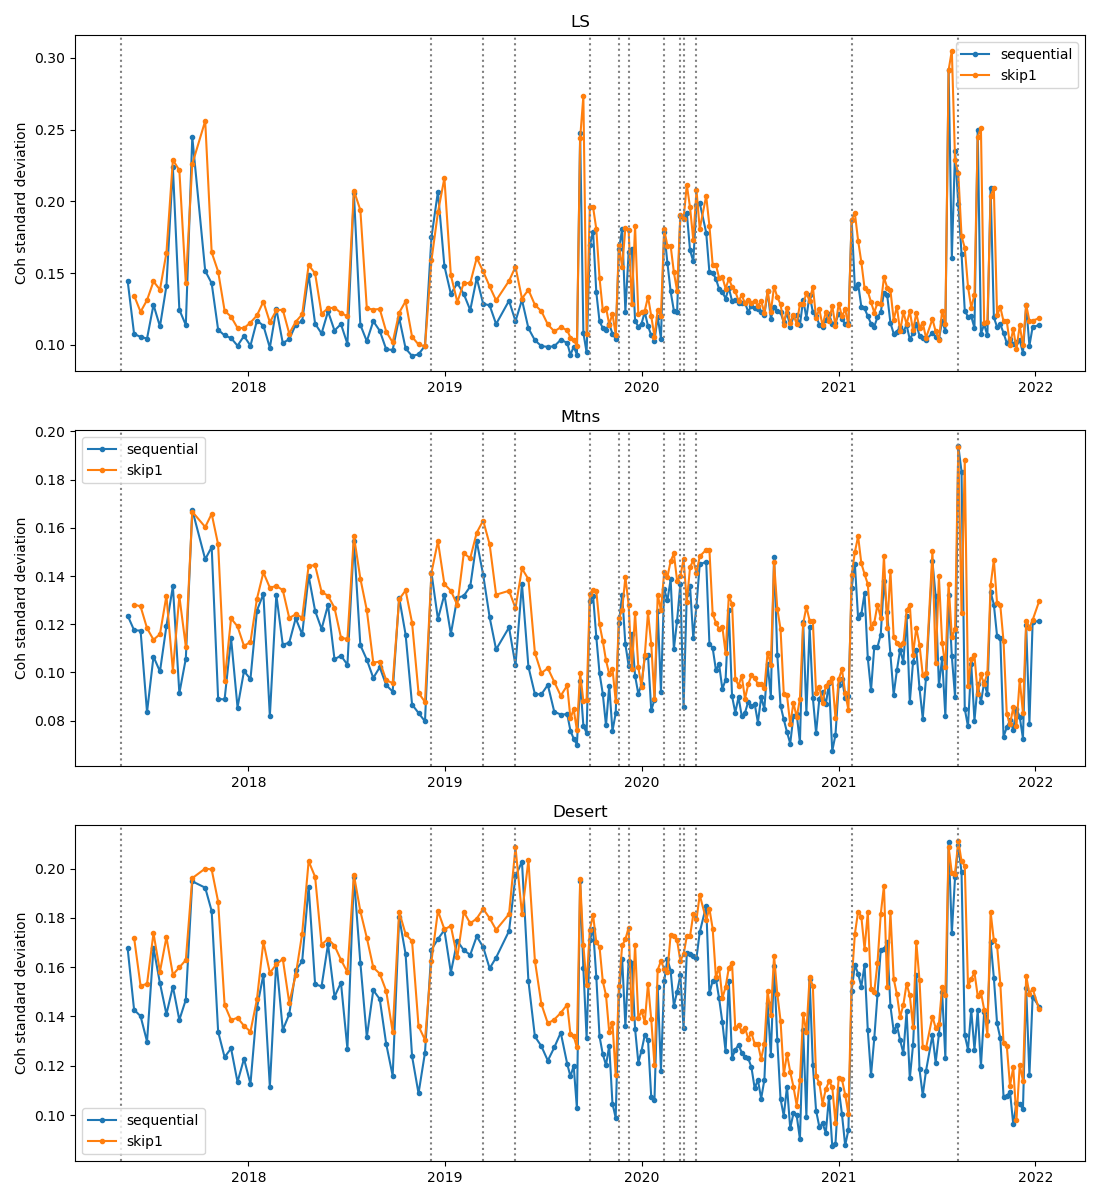

In [19]:
plt.figure(figsize=(11,4*3),tight_layout=True)

plt.subplot(3,1,1)
plt.plot(igram_dates,std_LS,'.-',label='sequential')
plt.plot(igram_dates_skip1,std_skip1_LS,'.-',label='skip1')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Coh standard deviation')
plt.title('LS')

plt.subplot(3,1,2)
plt.plot(igram_dates,std_mtns,'.-',label='sequential')
plt.plot(igram_dates_skip1,std_skip1_mtns,'.-',label='skip1')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Coh standard deviation')
plt.title('Mtns')

plt.subplot(3,1,3)
plt.plot(igram_dates,std_desert,'.-',label='sequential')
plt.plot(igram_dates_skip1,std_skip1_desert,'.-',label='skip1')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Coh standard deviation')
plt.title('Desert')
plt.show()

Try subtracting sequential coh - skip1 coh and plot for each surface type. Then do for std.

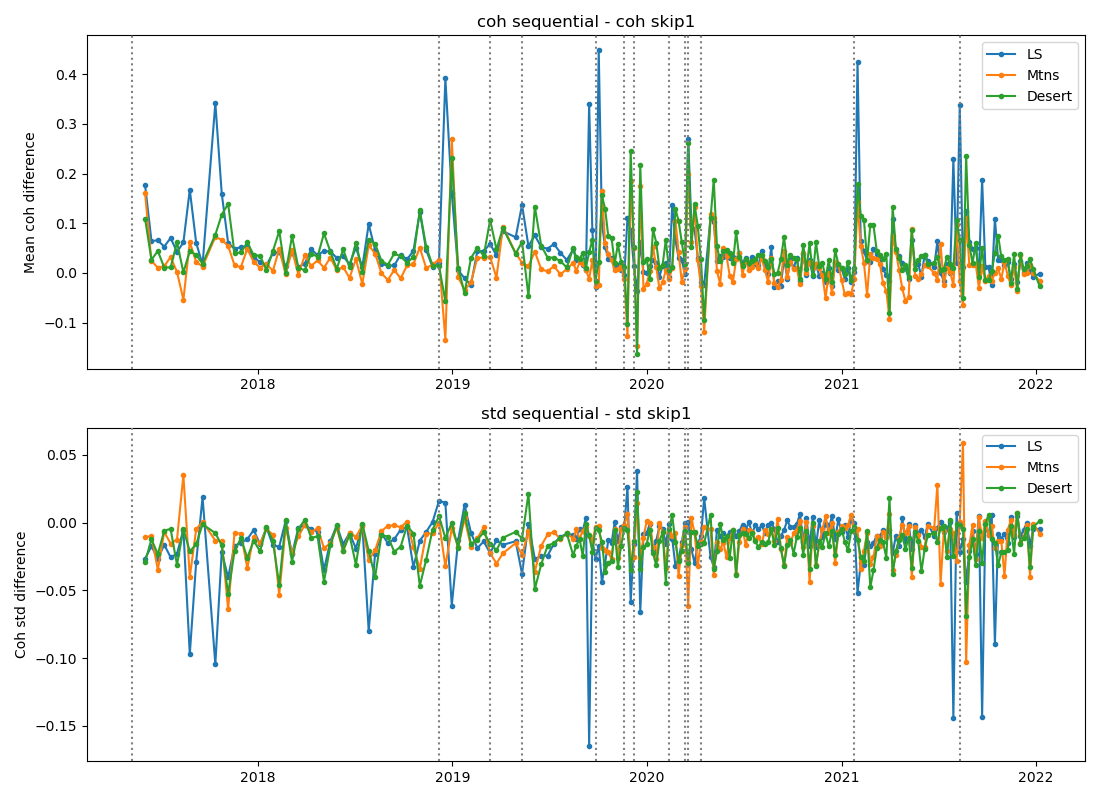

In [23]:
plt.figure(figsize=(11,4*2),tight_layout=True)

plt.subplot(2,1,1)
plt.plot(igram_dates_skip1,coh_LS[1::]-coh_skip1_LS,'.-',label='LS')
plt.plot(igram_dates_skip1,coh_mtns[1::]-coh_skip1_mtns,'.-',label='Mtns')
plt.plot(igram_dates_skip1,coh_desert[1::]-coh_skip1_desert,'.-',label='Desert')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Mean coh difference')
plt.title('coh sequential - coh skip1')

plt.subplot(2,1,2)
plt.plot(igram_dates_skip1,std_LS[1::]-std_skip1_LS,'.-',label='LS')
plt.plot(igram_dates_skip1,std_mtns[1::]-std_skip1_mtns,'.-',label='Mtns')
plt.plot(igram_dates_skip1,std_desert[1::]-std_skip1_desert,'.-',label='Desert')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax]); plt.legend(); plt.ylabel('Coh std difference')
plt.title('std sequential - std skip1')
plt.show()